In [7]:
### Function Imports
from OptionsFunctions import set_price_and_strike, daily_returns, compute_sigma, black_scholes, hedge_pos_and_rets, calculate_hedged_unhedged, plot_hedged_returns
import pandas as pd
import numpy as np


In [8]:
### Variable Declaration
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
start_date = '2023-07-01'
end_date = '2024-07-01'
long_pos = 1000
option_type = 'call'
r = 0.02
r_f = 0.01
T = 1


In [9]:
### Compute Hedged Returns for All Pairs and Filter to find most Profitable
hedge_ratios_df = pd.DataFrame(columns = ['Pair', 'Option Type', 'Option Premium', 'Delta', 'Long Position', 'Short Position', 'Hedged Returns', 'Unhedged Returns'])

for pair in all_forex_pairs:
    try:
        # Assuming the functions 'set_price_and_strike', 'daily_returns', 'black_scholes', 'hedge_position', and 'calculate_hedged_unhedged' are defined elsewhere
        forex_data, S_0, K = set_price_and_strike(pair, start_date, end_date, option_type = 'call')
        daily_rets = daily_returns(forex_data)
        sigma = compute_sigma(daily_rets)
        option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type = 'call')
        hedge_pos, hedged_rets = hedge_pos_and_rets(daily_rets, delta, long_pos)
        hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)

        new_row = pd.DataFrame({
            'Pair': [pair],
            'Option Type': [option_type],
            'Option Premium': [option_price],
            'Delta': [delta],
            'Long Position': [long_pos],
            'Short Position': [hedge_pos],
            'Hedged Returns': [hedged_cumulative_rets.iloc[-1] if not hedged_cumulative_rets.empty else None],
            'Unhedged Returns': [unhedged_cumulative_rets.iloc[-1] if not unhedged_cumulative_rets.empty else None]
        })

        hedge_ratios_df = pd.concat([hedge_ratios_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Error computing hedge ratio for {pair}: {e}")

#print(hedge_ratios_df.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
### Filter for Most Profitable Hedged Pairing
# Sort the DataFrame by the 'Hedged Returns' column in descending order
most_profit_hedged = hedge_ratios_df.sort_values(by = 'Hedged Returns', ascending = False).head(1)
#print(most_profit_hedged)

### Display Results
high_pair = most_profit_hedged.iloc[0]['Pair']
option_type = most_profit_hedged.iloc[0]['Option Type']
high_option_premium = most_profit_hedged.iloc[0]['Option Premium']
high_long_position = most_profit_hedged.iloc[0]['Long Position']
high_short_position = most_profit_hedged.iloc[0]['Short Position']
high_hedged_returns = most_profit_hedged.iloc[0]['Hedged Returns']
high_unhedged_returns = most_profit_hedged.iloc[0]['Unhedged Returns']

print(f"Most Profitable Pairing: {high_pair}")
print(f"Option Type: {option_type}")
print(f"Option Premium: {high_option_premium:.6f}")
print(f"Long Position: {high_long_position}")
print(f"Short Position: {high_short_position:.6f}")
print("\nReturns:")
print(f"Hedged Returns: {high_hedged_returns:.6f}")
print(f"Unhedged Returns: {high_unhedged_returns:.6f}")


Most Profitable Pairing: USDJPY=X
Option Type: call
Option Premium: 4.627643
Long Position: 1000
Short Position: -465.770331

Returns:
Hedged Returns: 1059.732616
Unhedged Returns: 1112.806286


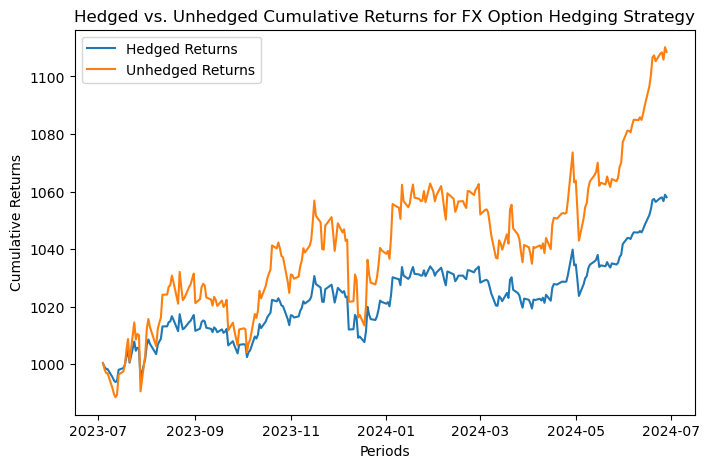

In [11]:
### Plot Hedged vs. Unhedged Returns
plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets)


In [12]:
### Function to Compute Performance Metrics
def performance_metrics(pair, long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, returns, r_dom, r_for):
    # Ensure there are no NaN values that could skew the results
    hedged_cumulative_rets = hedged_cumulative_rets.dropna()
    unhedged_cumulative_rets = unhedged_cumulative_rets.dropna()

    # Compute Total Returns (Current - Initial)
    hedged_total_rets = hedged_cumulative_rets.iloc[-1] - long_pos
    unhedged_total_rets = unhedged_cumulative_rets.iloc[-1] - long_pos

    # Compute Annualized Returns
    hedged_ann_rets = (1 + hedged_total_rets / long_pos) ** (252 / len(returns)) - 1
    unhedged_ann_rets = (1 + unhedged_total_rets / long_pos) ** (252 / len(returns)) - 1

    # Compute Mean Returns
    hedged_mean = np.mean(hedged_cumulative_rets)
    unhedged_mean = np.mean(unhedged_cumulative_rets)

    # Compute Standard Deviation
    hedged_stddev = np.std(hedged_cumulative_rets)
    unhedged_stddev = np.std(unhedged_cumulative_rets)

    # Compute Sharpe Ratios using the domestic risk-free rate for local valuation and adjustments
    hedged_sharpe_ratio = (hedged_mean / long_pos - r_dom) / hedged_stddev * np.sqrt(252)
    unhedged_sharpe_ratio = (unhedged_mean / long_pos - r_dom) / unhedged_stddev * np.sqrt(252)

    # Print formatted results
    print(f"{'Metric':<30} {'Hedged':>15} {'Unhedged':>15}")
    print("="*60)
    print(f"{'Total Returns':<30} {hedged_total_rets:>15.4f} {unhedged_total_rets:>15.4f}")
    print(f"{'Annualized Returns':<30} {hedged_ann_rets:>15.4f} {unhedged_ann_rets:>15.4f}")
    print(f"{'Mean Return':<30} {hedged_mean:>15.4f} {unhedged_mean:>15.4f}")
    print(f"{'Standard Deviation':<30} {hedged_stddev:>15.4f} {unhedged_stddev:>15.4f}")
    print(f"{'Sharpe Ratio':<30} {hedged_sharpe_ratio:>15.4f} {unhedged_sharpe_ratio:>15.4f}")

    # Explanation of Sharpe Ratio in print statements
    print(f"\nThe Sharpe ratio measures the risk-adjusted return of an investment.")
    print(f"In this instance, the hedged strategy has a Sharpe ratio of {hedged_sharpe_ratio:.4f},")
    print(f"which means for every unit of risk, the hedged portfolio is generating {hedged_sharpe_ratio:.4f} units of return above the risk-free rate.")
    print(f"The unhedged strategy has a Sharpe ratio of {unhedged_sharpe_ratio:.4f},")
    print(f"indicating that for every unit of risk, the unhedged portfolio is generating {unhedged_sharpe_ratio:.4f} units of return above the risk-free rate.")
    print(f"A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.")

# Example usage
performance_metrics(high_pair, long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, daily_rets, r, r_f)


Metric                                  Hedged        Unhedged
Total Returns                          58.0344        108.4864
Annualized Returns                      0.0564          0.1054
Mean Return                          1022.7909       1041.8966
Standard Deviation                     13.2192         24.5886
Sharpe Ratio                            1.2042          0.6597

The Sharpe ratio measures the risk-adjusted return of an investment.
In this instance, the hedged strategy has a Sharpe ratio of 1.2042,
which means for every unit of risk, the hedged portfolio is generating 1.2042 units of return above the risk-free rate.
The unhedged strategy has a Sharpe ratio of 0.6597,
indicating that for every unit of risk, the unhedged portfolio is generating 0.6597 units of return above the risk-free rate.
A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.
